<a href="https://www.kaggle.com/code/botaylaamin/arabic-alphabets-sign-language?scriptVersionId=263769558" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [24]:
import os
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='librosa')

import numpy as np
import pandas as pd
import seaborn as sns
import librosa
import shutil
from io import BytesIO
from PIL import Image, ImageOps, ImageFile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras import mixed_precision
# Handle truncated image warnings in PIL
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


# *Dataset Path & Parameters*

In [25]:
path = '/kaggle/input/arabic-alphabets-sign-language-dataset-arasl/ArASL_Database_54K_Final/ArASL_Database_54K_Final'
img_size = 224
batch_size = 32
val_split = 0.2
seed = 42

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = torch.amp.GradScaler(device="cuda")

# *EDA (Exploratory Data Analysis)*

In [9]:
classes = sorted(os.listdir(path))
num_classes = len(classes)
print("Number of classes:", num_classes)
print("Class indices mapping:", {class_name: idx for idx, class_name in enumerate(classes)})

Number of classes: 32
Class indices mapping: {'ain': 0, 'al': 1, 'aleff': 2, 'bb': 3, 'dal': 4, 'dha': 5, 'dhad': 6, 'fa': 7, 'gaaf': 8, 'ghain': 9, 'ha': 10, 'haa': 11, 'jeem': 12, 'kaaf': 13, 'khaa': 14, 'la': 15, 'laam': 16, 'meem': 17, 'nun': 18, 'ra': 19, 'saad': 20, 'seen': 21, 'sheen': 22, 'ta': 23, 'taa': 24, 'thaa': 25, 'thal': 26, 'toot': 27, 'waw': 28, 'ya': 29, 'yaa': 30, 'zay': 31}


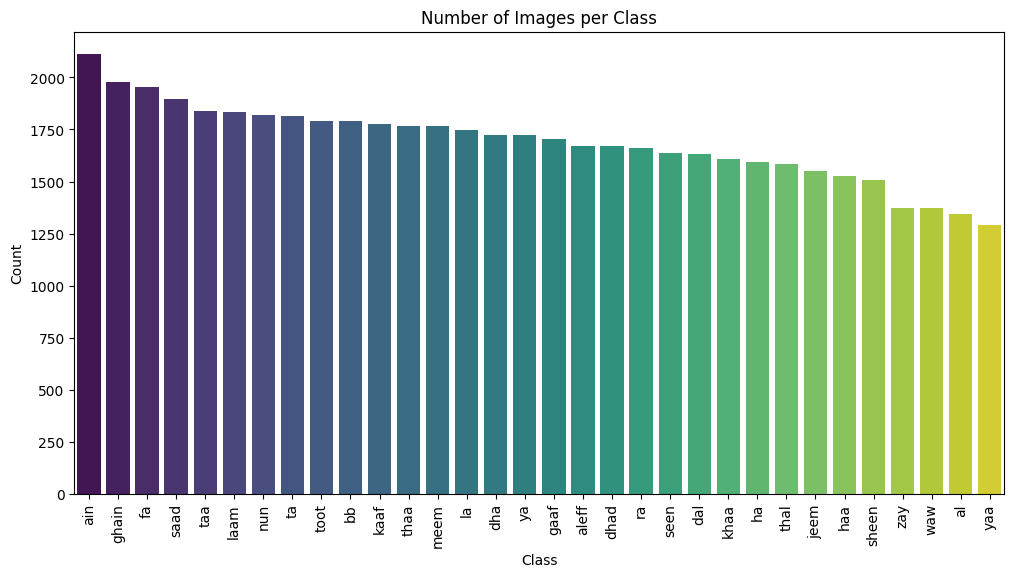

In [10]:
class_counts = {}
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])
df_counts = df_counts.sort_values("Count", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=df_counts, x="Class", y="Count", palette="viridis")
plt.xticks(rotation=90)
plt.title("Number of Images per Class")
plt.show()

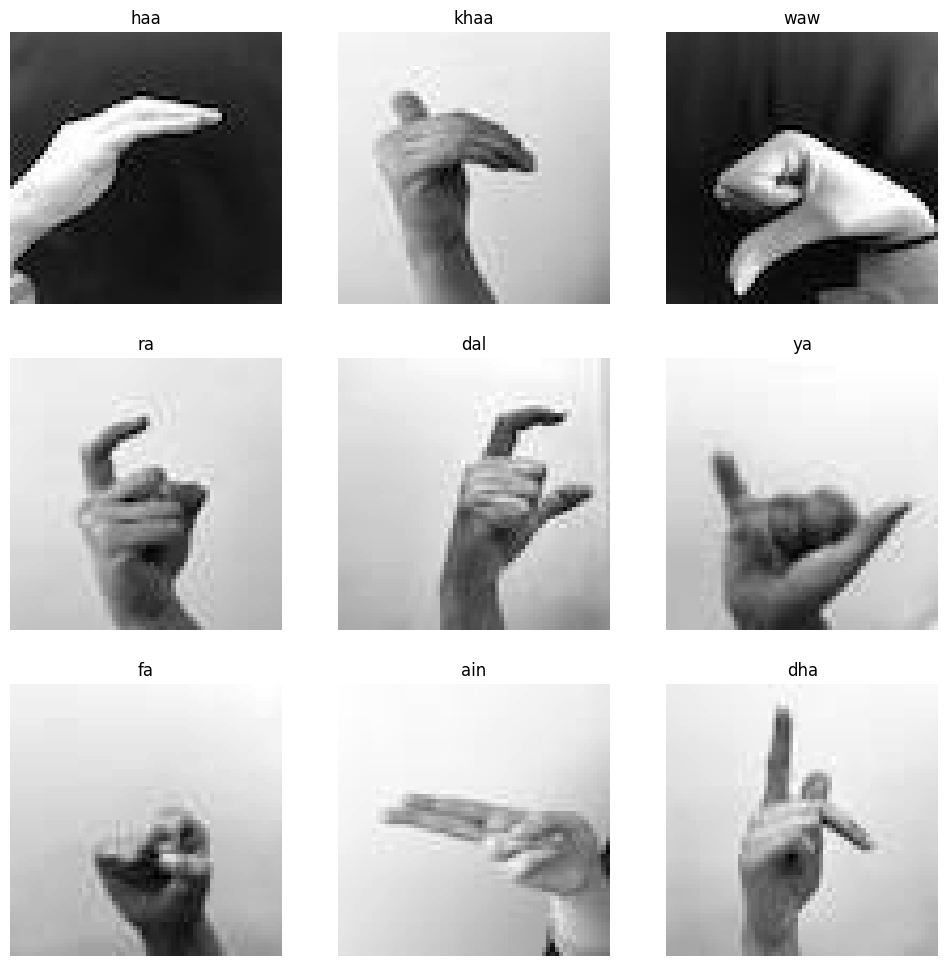

In [11]:
import random
plt.figure(figsize=(12,12))
classes = os.listdir(path)
for i in range(9):
    class_choice = random.choice(classes)
    class_path = os.path.join(path, class_choice)
    img_choice = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_choice)

    img = plt.imread(img_path)
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(class_choice)
    plt.axis("off")
plt.show()

# *Data Preparation*

In [26]:
torch.manual_seed(seed)

# Training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# Validation
val_transforms = transforms.Compose([
    transforms.Resize(int(img_size * 1.15)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])


# Load full dataset
full_dataset = datasets.ImageFolder(root=path, transform=train_transforms)

# Split into train and val
val_size = int(len(full_dataset) * val_split)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply different transforms for validation set
val_dataset.dataset.transform = val_transforms

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Class names
class_names = full_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Number of classes:", num_classes)

Classes: ['ain', 'al', 'aleff', 'bb', 'dal', 'dha', 'dhad', 'fa', 'gaaf', 'ghain', 'ha', 'haa', 'jeem', 'kaaf', 'khaa', 'la', 'laam', 'meem', 'nun', 'ra', 'saad', 'seen', 'sheen', 'ta', 'taa', 'thaa', 'thal', 'toot', 'waw', 'ya', 'yaa', 'zay']
Number of classes: 32


# *Building a Model*

## *MobileNetV1*

In [46]:
base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Freeze backbone
for param in base_model.features.parameters():
    param.requires_grad = False

# Replace classifier head 
base_model.classifier = nn.Sequential(
    nn.Dropout(0.4),                               
    nn.Linear(base_model.last_channel, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.4),
    nn.Linear(512, num_classes)                     
)

model = base_model.to(device)

criterion = nn.CrossEntropyLoss()

# optimizer setup
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Add learning rate scheduler
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=epochs
)

In [28]:
from copy import deepcopy

epochs = 25
patience = 7
best_loss = float("inf")
early_stop_counter = 0
best_model_wts = deepcopy(model.state_dict())

# Kaggle working dir for saving models
os.makedirs("/kaggle/working/checkpoints", exist_ok=True)
checkpoint_path = "/kaggle/working/checkpoints/best_model.pth"
final_model_path = "/kaggle/working/checkpoints/final_model.pth"

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    # Training 
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast("cuda"):   
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = running_loss / total
    
    #  Validation 
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.amp.autocast("cuda"):  
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_loss = running_loss / total
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    # Early Stopping + Checkpoint 
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = deepcopy(model.state_dict())
        torch.save(best_model_wts, checkpoint_path)  
        print(f"Best model saved at epoch {epoch+1}")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break

#  Load Best Weights 
model.load_state_dict(torch.load(checkpoint_path))
print("Loaded best model weights.")

#  Save Final Model
torch.save(model.state_dict(), final_model_path)
print(f" Final model saved to {final_model_path}")


Epoch 1/25
Train Loss: 2.5736 | Train Acc: 0.2879
Val Loss:   1.5443 | Val Acc:   0.6688
Best model saved at epoch 1

Epoch 2/25
Train Loss: 1.6157 | Train Acc: 0.5390
Val Loss:   1.0818 | Val Acc:   0.7441
Best model saved at epoch 2

Epoch 3/25
Train Loss: 1.3147 | Train Acc: 0.6158
Val Loss:   0.8975 | Val Acc:   0.7771
Best model saved at epoch 3

Epoch 4/25
Train Loss: 1.1815 | Train Acc: 0.6432
Val Loss:   0.7688 | Val Acc:   0.7977
Best model saved at epoch 4

Epoch 5/25
Train Loss: 1.0994 | Train Acc: 0.6623
Val Loss:   0.6978 | Val Acc:   0.8222
Best model saved at epoch 5

Epoch 6/25
Train Loss: 1.0449 | Train Acc: 0.6780
Val Loss:   0.6416 | Val Acc:   0.8314
Best model saved at epoch 6

Epoch 7/25
Train Loss: 1.0136 | Train Acc: 0.6826
Val Loss:   0.6180 | Val Acc:   0.8357
Best model saved at epoch 7

Epoch 8/25
Train Loss: 0.9865 | Train Acc: 0.6916
Val Loss:   0.5885 | Val Acc:   0.8424
Best model saved at epoch 8

Epoch 9/25
Train Loss: 0.9667 | Train Acc: 0.6940
Val L

## *EfficientNetB0*

In [33]:
base_model = models.efficientnet_b0(weights="IMAGENET1K_V1")  

# Freeze backbone
for param in base_model.parameters():
    param.requires_grad = False

# Number of features in the last layer
in_features = base_model.classifier[1].in_features  

# Custom classifier head
classifier = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)

# Replace the default classifier
base_model.classifier = classifier
model = base_model.to(device)

# Optimizer & Loss 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [34]:
epochs = 25
patience = 7
best_loss = float("inf")
early_stop_counter = 0
best_model_wts = deepcopy(model.state_dict())

# Kaggle save dir
os.makedirs("/kaggle/working/effecientnetcheckpoints", exist_ok=True)
checkpoint_path = "/kaggle/working/effecientnetcheckpoints/best_efficientnetb0.pth"
final_model_path = "/kaggle/working/final_efficientnetb0.pth"

scaler = torch.amp.GradScaler("cuda")

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast("cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / total
    val_acc = correct / total

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

    # Early Stopping + Checkpoint
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = deepcopy(model.state_dict())
        torch.save(best_model_wts, checkpoint_path)
        print(f"Best EfficientNetB0 model saved at epoch {epoch+1}")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break

# Load best weights
model.load_state_dict(torch.load(checkpoint_path))
print("Loaded best EfficientNetB0 weights.")

# Save final model
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")


Epoch 1/25
Train Loss: 1.1876 | Train Acc: 0.6381
Val Loss:   0.4431 | Val Acc:   0.8754
Best EfficientNetB0 model saved at epoch 1

Epoch 2/25
Train Loss: 0.6517 | Train Acc: 0.7903
Val Loss:   0.3092 | Val Acc:   0.9090
Best EfficientNetB0 model saved at epoch 2

Epoch 3/25
Train Loss: 0.5409 | Train Acc: 0.8261
Val Loss:   0.2674 | Val Acc:   0.9256
Best EfficientNetB0 model saved at epoch 3

Epoch 4/25
Train Loss: 0.4662 | Train Acc: 0.8484
Val Loss:   0.2353 | Val Acc:   0.9307
Best EfficientNetB0 model saved at epoch 4

Epoch 5/25
Train Loss: 0.4339 | Train Acc: 0.8589
Val Loss:   0.2021 | Val Acc:   0.9417
Best EfficientNetB0 model saved at epoch 5

Epoch 6/25
Train Loss: 0.4067 | Train Acc: 0.8668
Val Loss:   0.1881 | Val Acc:   0.9452
Best EfficientNetB0 model saved at epoch 6

Epoch 7/25
Train Loss: 0.3838 | Train Acc: 0.8745
Val Loss:   0.2230 | Val Acc:   0.9321

Epoch 8/25
Train Loss: 0.3646 | Train Acc: 0.8799
Val Loss:   0.1769 | Val Acc:   0.9467
Best EfficientNetB0 mo

# **Model Evaluation**

## MobileNet

In [47]:
# Load saved model for evaluation as model variable is overwritten
num_classes = len(class_names) 

base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Freeze 
for param in base_model.features.parameters():
    param.requires_grad = False

# Custom classifier 
base_model.classifier = nn.Sequential(
    nn.Dropout(0.4),                               
    nn.Linear(base_model.last_channel, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.4),
    nn.Linear(512, num_classes)                     
)

# Move to device
mobilenet_model = base_model.to(device)

# Load saved weights
mobilenet_model.load_state_dict(torch.load("/kaggle/working/final_model.pth", map_location=device))
mobilenet_model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [48]:
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:   
        images, labels = images.to(device), labels.to(device)
        with torch.amp.autocast("cuda"):
            outputs = mobilenet_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

         ain       0.96      0.98      0.97       413
          al       0.95      0.93      0.94       281
       aleff       0.97      0.94      0.95       315
          bb       0.85      0.91      0.88       349
         dal       0.91      0.87      0.89       308
         dha       0.90      0.88      0.89       339
        dhad       0.92      0.90      0.91       332
          fa       0.81      0.87      0.84       412
        gaaf       0.81      0.79      0.80       340
       ghain       0.95      0.91      0.93       384
          ha       0.84      0.84      0.84       314
         haa       0.92      0.88      0.90       333
        jeem       0.88      0.90      0.89       292
        kaaf       0.90      0.85      0.87       338
        khaa       0.91      0.91      0.91       313
          la       0.90      0.91      0.91       357
        laam       0.92      0.93      0.93       380
   

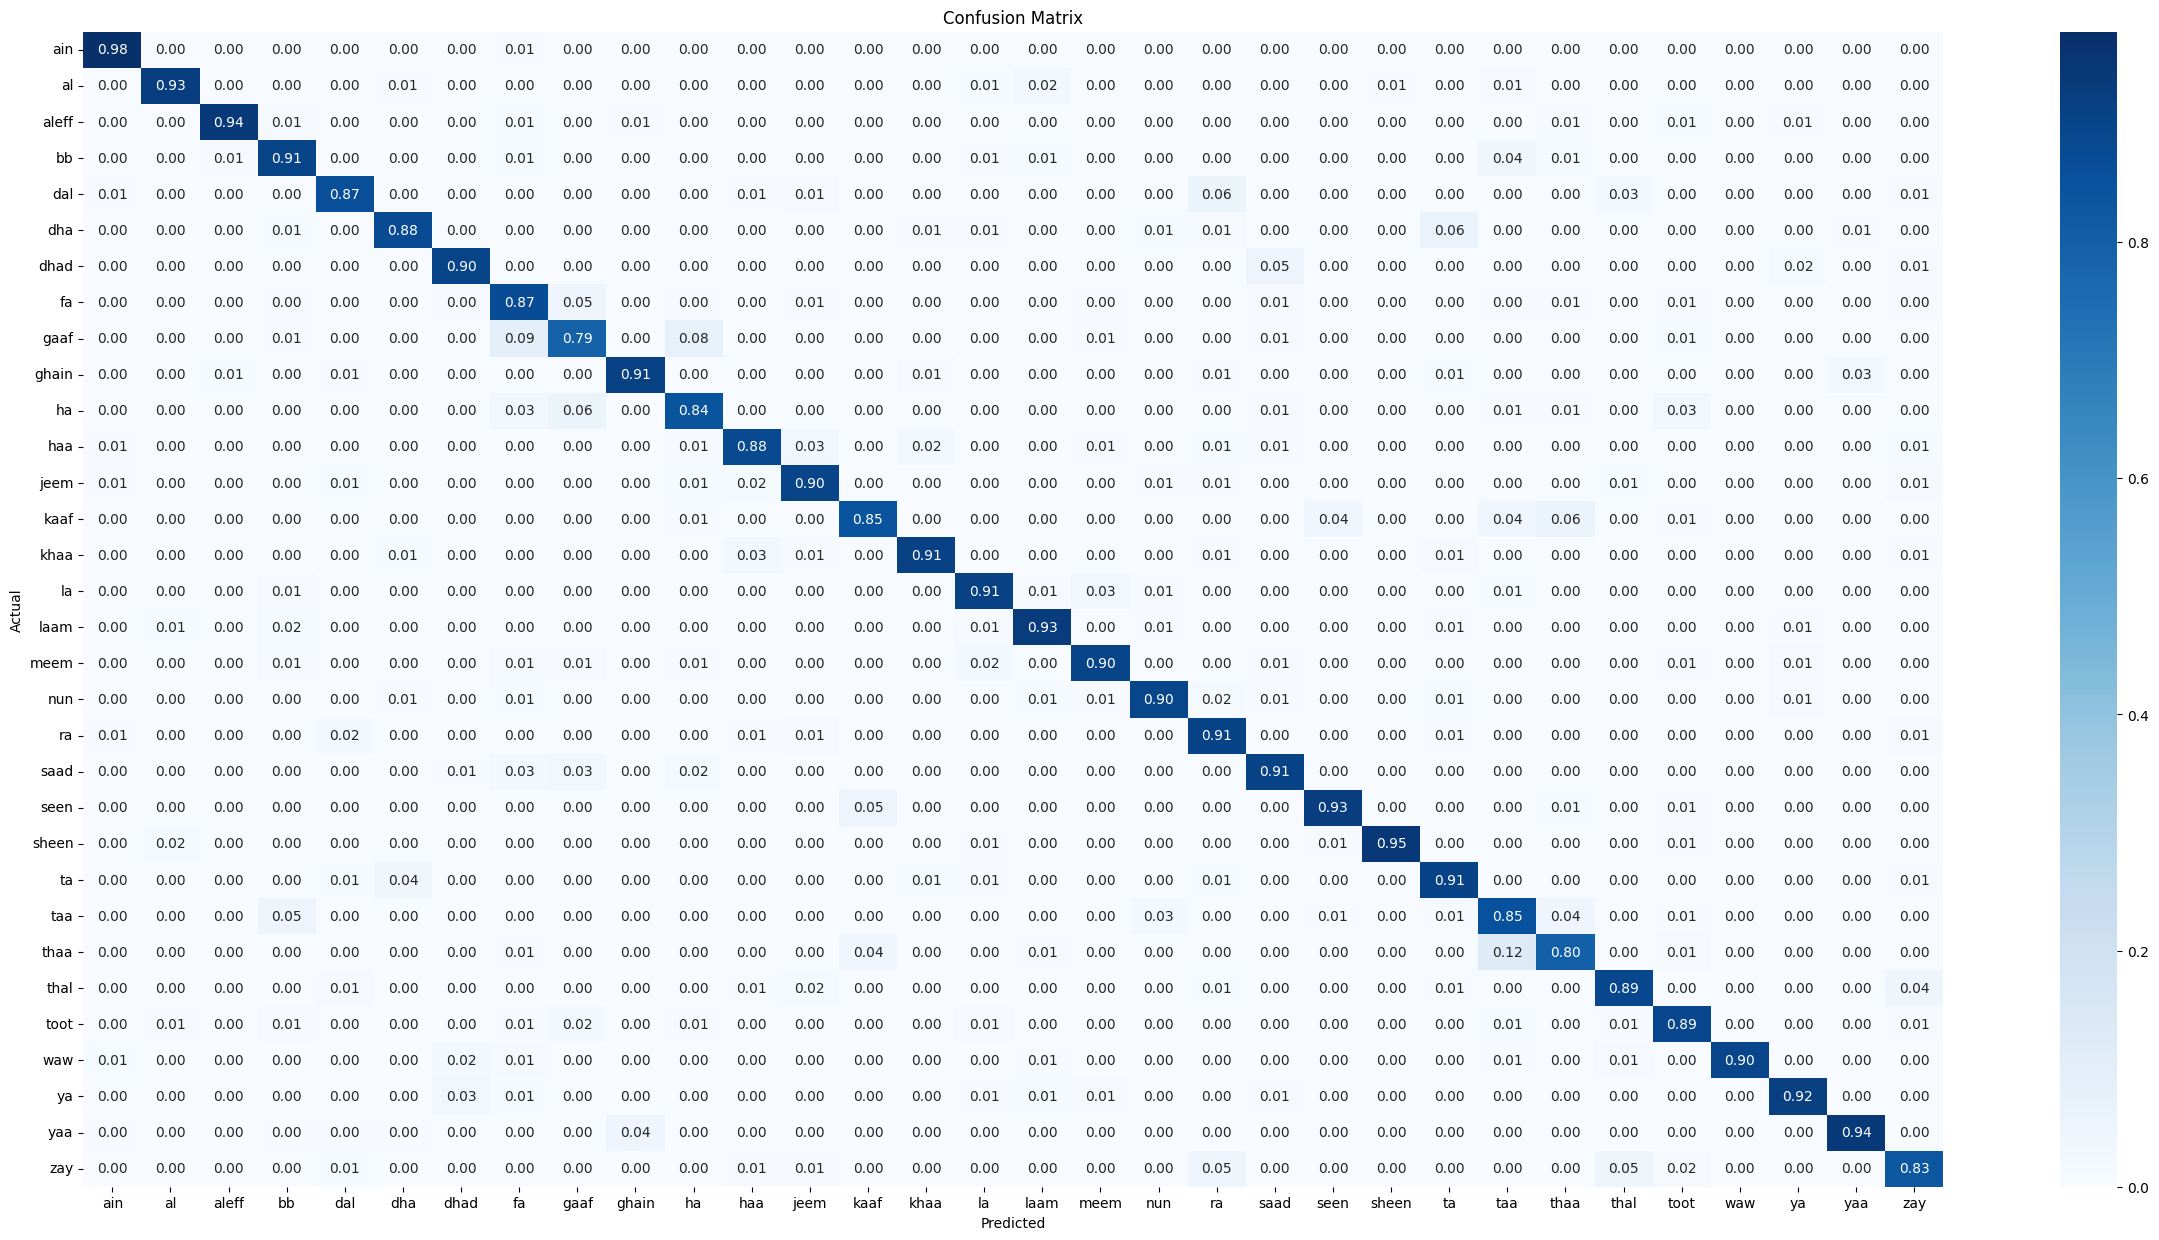

In [49]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(30, 15))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## EffecientNetB0

In [41]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:   
        images, labels = images.to(device), labels.to(device)
        with torch.amp.autocast("cuda"):
            outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report ''
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


 Classification Report:
              precision    recall  f1-score   support

         ain       0.99      1.00      0.99       413
          al       0.96      0.97      0.96       281
       aleff       0.98      0.95      0.96       315
          bb       0.98      0.97      0.97       349
         dal       0.90      0.95      0.93       308
         dha       0.96      0.94      0.95       339
        dhad       0.97      0.96      0.97       332
          fa       0.95      0.93      0.94       412
        gaaf       0.93      0.93      0.93       340
       ghain       0.98      0.97      0.98       384
          ha       0.94      0.95      0.95       314
         haa       0.94      0.96      0.95       333
        jeem       0.93      0.93      0.93       292
        kaaf       0.96      0.95      0.95       338
        khaa       0.96      0.95      0.95       313
          la       0.94      0.99      0.97       357
        laam       0.98      0.96      0.97       380
  

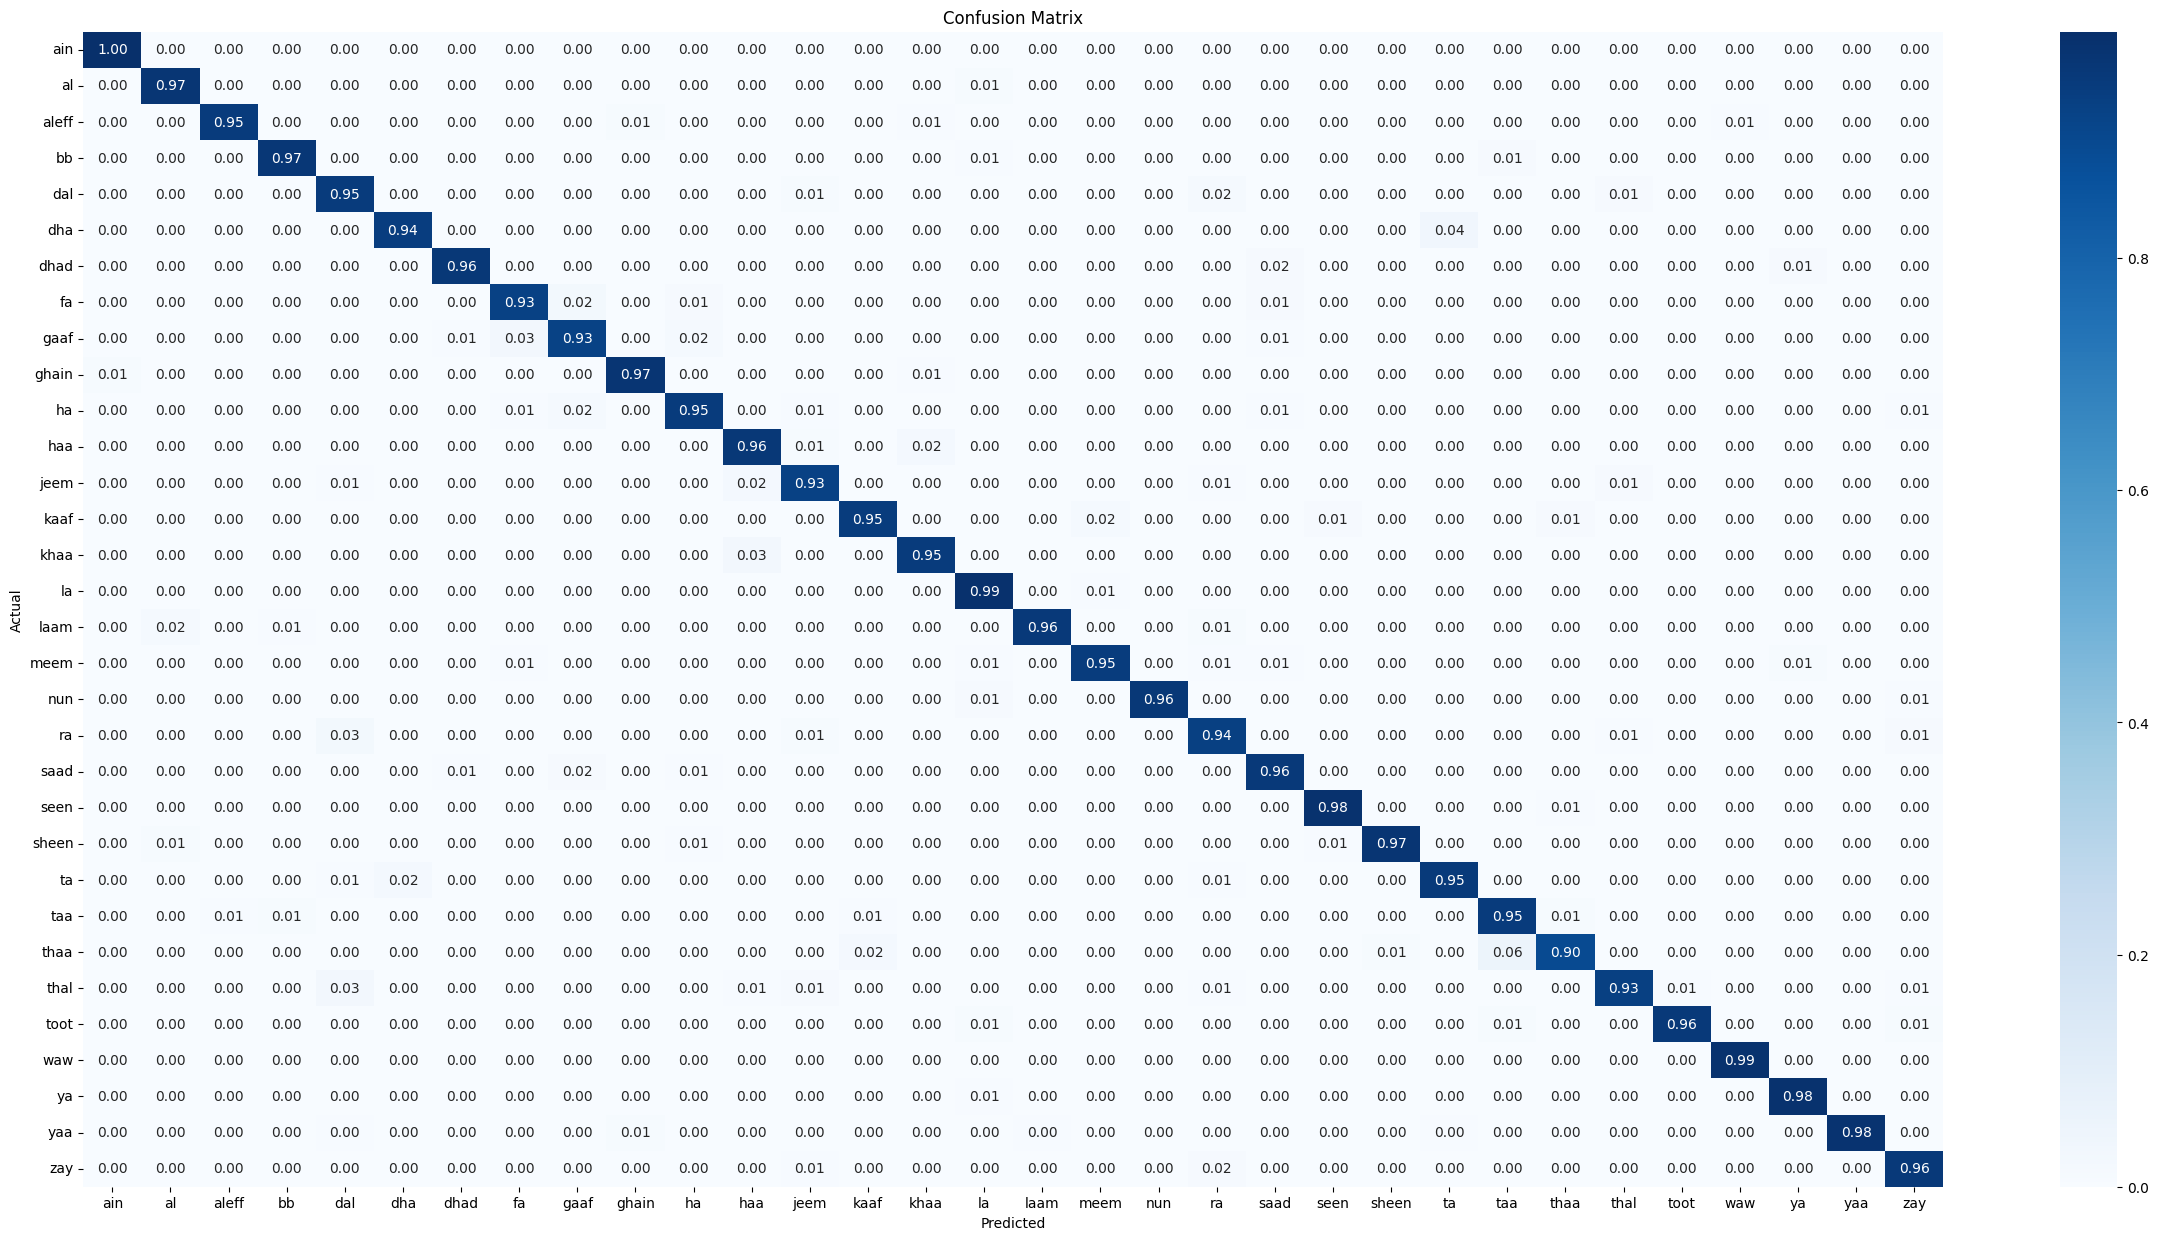

In [42]:
# Confusion Matrix 
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(30,15))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()